# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 设置 ROOT_DIR 为 project 根目录（即包含 RCNN_model 的那层）
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_DIR)

print("ROOT_DIR:", ROOT_DIR)

# Import Mask R-CNN 模块
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# 日志路径
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# 权重路径
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


ROOT_DIR: /Users/evanchan19/Desktop/COMP9517/project


Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
from mrcnn.config import Config

class USAConfig(Config):
    """Configuration for training on the USA RGB segmentation dataset.
    Derives from the base Config class and overrides values specific
    to the USA project data.
    """
    # Give the configuration a recognizable name
    NAME = "usa_rgb"

    # Train on 1 GPU and 2 images per GPU. Batch size = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 object class

    # Resize mode and dimensions
    # Resize images such that the smaller side = 384 and pad to square shape (max 512)
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 512
    IMAGE_RESIZE_MODE = "square"

    # Use medium-sized anchors since objects are not tiny
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # ROIs per image during training (default is 200)
    TRAIN_ROIS_PER_IMAGE = 200

    # Number of steps per training epoch
    STEPS_PER_EPOCH = 100

    # Number of steps for validation/testing
    VALIDATION_STEPS = 5
    
    # Training optimization
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9
    
    USE_MINI_MASK = False
    
    # # Set a slightly higher confidence threshold for final detections
    # DETECTION_MIN_CONFIDENCE = 0.85

config = USAConfig()
# config.display()

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

# Step 1) Data_Preprocessing

In [4]:
import os
import numpy as np
import cv2
from mrcnn import utils

class USADataset(utils.Dataset):
    def __init__(self, input_type="RGB"):
        """
        input_type: "RGB" or "NRG"
        """
        super().__init__()
        assert input_type in ["RGB", "NRG"]
        self.input_type = input_type

    def load_usa(self, dataset_dir, subset):
        """
        dataset_dir: root path of dataset (e.g. ".../USA_segmentation")
        subset: "train" or "val"
        """
        assert subset in ["train", "val"]

        image_dir = os.path.join(dataset_dir, subset, f"{self.input_type}_images")
        mask_dir = os.path.join(dataset_dir, subset, "masks")

        # Add class once (just one foreground class)
        self.add_class("usa", 1, "object")

        for filename in os.listdir(image_dir):
            if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
                continue

            img_path = os.path.join(image_dir, filename)

            # Adjust mask filename to match naming convention
            # e.g. RGB_ar123.png -> mask_ar123.png
            core_name = filename.replace(f"{self.input_type}_", "")
            mask_filename = f"mask_{core_name}"
            mask_path = os.path.join(mask_dir, mask_filename)

            if not os.path.exists(mask_path):
                continue

            # Load shape
            img = cv2.imread(img_path)
            height, width = img.shape[:2]

            self.add_image(
                "usa",
                image_id=filename,
                path=img_path,
                width=width,
                height=height,
                mask_path=mask_path
            )

    def load_image(self, image_id):
        info = self.image_info[image_id]
        img = cv2.imread(info["path"])

        if img is None:
            raise ValueError(f"Failed to load image: {info['path']}")

        # OpenCV loads BGR by default
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        mask_img = cv2.imread(info["mask_path"], cv2.IMREAD_GRAYSCALE)

        binary_mask = (mask_img == 255).astype(np.uint8)
        num_labels, labels = cv2.connectedComponents(binary_mask)

        masks = []
        for i in range(1, num_labels):  # Skip background
            masks.append((labels == i).astype(np.uint8))

        if masks:
            masks = np.stack(masks, axis=-1)
        else:
            masks = np.zeros((mask_img.shape[0], mask_img.shape[1], 0), dtype=np.uint8)

        class_ids = np.ones(masks.shape[-1], dtype=np.int32)
        return masks.astype(bool), class_ids
    
import keras
import matplotlib.pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_loss = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_loss.append(logs.get("loss"))
        self.val_loss.append(logs.get("val_loss"))


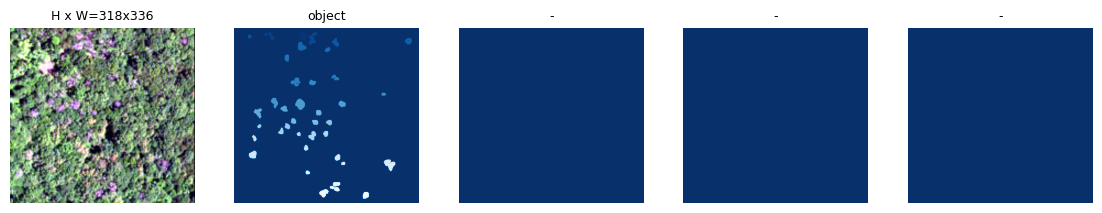

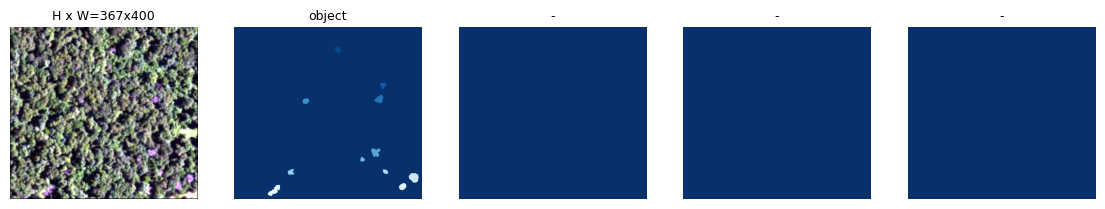

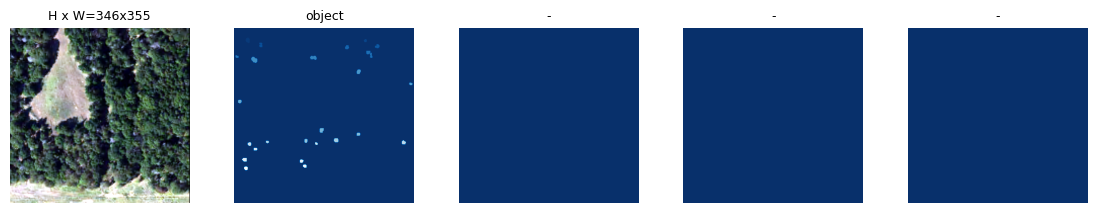

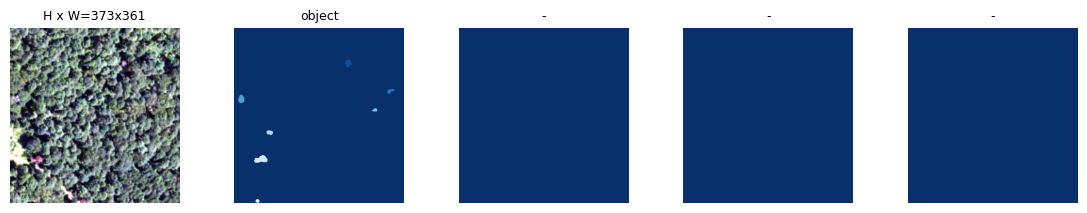

In [5]:
from mrcnn import visualize
import numpy as np

dataset_rgb = USADataset(input_type="RGB")
dataset_rgb.load_usa("/Users/evanchan19/Desktop/COMP9517/project/data/USA_segmentation", "train")
dataset_rgb.prepare()

dataset_val = USADataset(input_type="RGB")
dataset_val.load_usa("/Users/evanchan19/Desktop/COMP9517/project/data/USA_segmentation", "val")
dataset_val.prepare()

# 随机选 4 张图像
image_ids = np.random.choice(dataset_rgb.image_ids, 4)

for image_id in image_ids:
    image = dataset_rgb.load_image(image_id)
    mask, class_ids = dataset_rgb.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_rgb.class_names)

# Choice 2) NRG input type
# dataset_nrg = USADataset(input_type="NRG")
# dataset_nrg.load_usa("/Users/evanchan19/Desktop/COMP9517/project/data/USA_segmentation", "train")
# dataset_nrg.prepare()

# dataset_val = USADataset(input_type="NRG")
# dataset_val.load_usa("/Users/evanchan19/Desktop/COMP9517/project/data/USA_segmentation", "val")
# dataset_val.prepare()

# image_ids = np.random.choice(dataset_nrg.image_ids, 4)

# for image_id in image_ids:
#     image = dataset_nrg.load_image(image_id)
#     mask, class_ids = dataset_nrg.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_nrg.class_names)

## Create Model

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [7]:
# ========================================
# Which weights to start with?
# ========================================
# You can choose one of the following options to initialize the Mask R-CNN model:
# 
# 1. "imagenet":
#    - Loads weights pretrained on ImageNet.
#    - Only the ResNet backbone is initialized (no RPN, head, or mask layers).
#    - Useful if training from scratch, but generally slower convergence.
#
# 2. "coco":
#    - Loads weights pretrained on MS COCO (mask_rcnn_coco.h5).
#    - Excludes the last layers ("mrcnn_class_logits", "mrcnn_bbox_fc",
#      "mrcnn_bbox", "mrcnn_mask") because your number of classes is likely different.
#    - Recommended for most use cases, especially if your dataset is small.
#
# 3. "last":
#    - Loads the last trained model (from your logs folder).
#    - Useful for resuming training or fine-tuning.

init_with = "coco"      

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)

2025-07-24 12:06:29.189961: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-07-24 12:06:29.206316: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f88910fb830 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-07-24 12:06:29.206332: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# ============================================================
# Train the Mask R-CNN model on your custom USA RGB dataset
# ============================================================

# Train the head branches
# Passing layers="heads" freezes all layers except the head layers.
# You can also pass a regular expression to select which layers to train by name pattern.
# Since you're using a custom dataset with RGB input and a single "object" class,
# training only the heads first is a good strategy.

# You can later try:
#   layers="all" for full fine-tuning
#   or use NRG input by switching input_type="NRG" in USADataset

history = LossHistory()

model.train(dataset_rgb, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads',
            custom_callbacks=[history])  



Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/evanchan19/Desktop/COMP9517/project/logs/usa_rgb20250724T1206/mask_rcnn_usa_rgb_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Time

/Users/evanchan19/miniconda3/envs/rcnn_dev/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/evanchan19/miniconda3/envs/rcnn_dev/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/evanchan19/miniconda3/envs/rcnn_dev/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/10
100/100 [==============================] - 1952s 20s/step - loss: 2.8701 - rpn_class_loss: 0.5801 - rpn_bbox_loss: 0.8486 - mrcnn_class_loss: 0.2227 - mrcnn_bbox_loss: 0.6460 - mrcnn_mask_loss: 0.5727 - val_loss: 2.5013 - val_rpn_class_loss: 0.3397 - val_rpn_bbox_loss: 0.7568 - val_mrcnn_class_loss: 0.2085 - val_mrcnn_bbox_loss: 0.6689 - val_mrcnn_mask_loss: 0.5274

Epoch 2/10
100/100 [==============================] - 1928s 19s/step - loss: 2.3673 - rpn_class_loss: 0.3234 - rpn_bbox_loss: 0.7815 - mrcnn_class_loss: 0.2126 - mrcnn_bbox_loss: 0.5380 - mrcnn_mask_loss: 0.5118 - val_loss: 2.3949 - val_rpn_class_loss: 0.3464 - val_rpn_bbox_loss: 0.7924 - val_mrcnn_class_loss: 0.2560 - val_mrcnn_bbox_loss: 0.4984 - val_mrcnn_mask_loss: 0.5016
Epoch 3/10
100/100 [==============================] - 1950s 20s/step - loss: 2.2426 - rpn_class_loss: 0.3118 - rpn_bbox_loss: 0.7257 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.4857 - mrcnn_mask_loss: 0.4794 - val_loss: 2.2797 - val_

KeyboardInterrupt: 

Re-starting from epoch 6

Starting at epoch 6. LR=0.001

Checkpoint Path: /Users/evanchan19/Desktop/COMP9517/project/logs/usa_rgb20250724T1206/mask_rcnn_usa_rgb_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrc

## Fine tune coding Training section

In [ ]:
# Fine tune all layers -> Passing layers="all" trains all layers. 
#You can also pass a regular expression to select which layers to
# train by name pattern.

# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=2, 
#             layers="all")

## Detection

Loading weights from  /Users/evanchan19/Desktop/COMP9517/project/logs/usa_rgb20250724T1206/mask_rcnn_usa_rgb_0010.h5
Re-starting from epoch 10
dataset_val.image_ids: [0 1 2 3 4]
len(image_info): 89
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


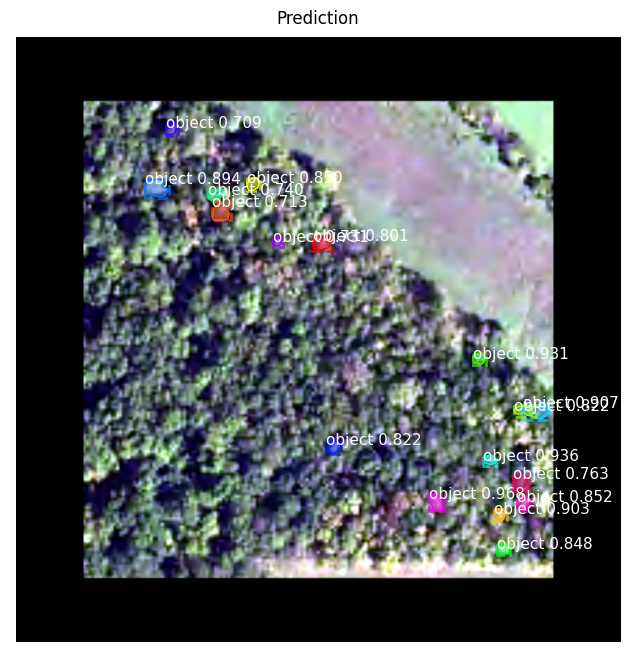

In [23]:
from mrcnn.config import Config

class InferenceConfig(Config):
    NAME = "usa_rgb"  
    NUM_CLASSES = 1 + 1  # Background + your class (adjust accordingly)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
inference_config = InferenceConfig()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

print("dataset_val.image_ids:", dataset_val.image_ids[:5])
print("len(image_info):", len(dataset_val.image_info))

# 1. Ground Truth 真实标注
image_id = dataset_val.image_ids[0]  
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
    
# 2. 模型预测和可视化
results = model.detect([original_image], verbose=1)
r = results[0]

visualize.display_instances(
    original_image,           # 原图
    r['rois'],                # 检测框
    r['masks'],               # 分割掩码
    r['class_ids'],           # 预测的类别
    dataset_val.class_names,  # 类别名称
    r['scores'],              # 每个预测的置信度分数
    figsize=(8, 8),
    title="Prediction"
)


## Evaluation

In [24]:
# Compute VOC-Style mAP @ IoU=0.5
image_ids = dataset_val.image_ids  # Or random subset if needed
APs = []

for image_id in image_ids:
    # Load GT
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    
    # Run detection (auto-molding included)
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP for this image
    AP, precisions, recalls, overlaps = utils.compute_ap(
        gt_bbox, gt_class_id, gt_mask,
        r["rois"], r["class_ids"], r["scores"], r['masks']
    )
    APs.append(AP)

# Final mAP
print("mAP @ IoU=0.5:", np.mean(APs))


mAP @ IoU=0.5: nan


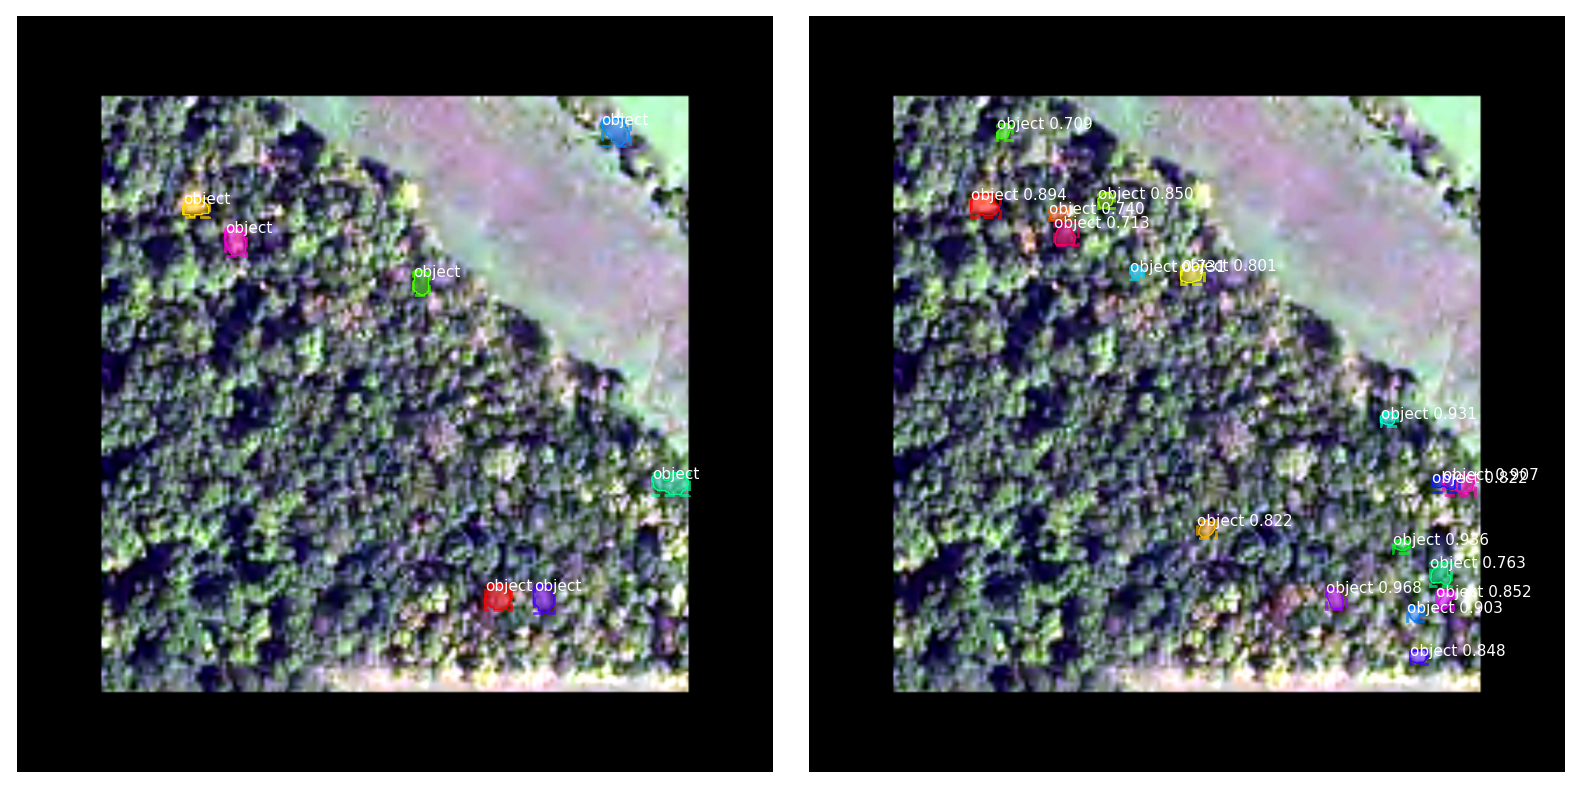

In [28]:
import matplotlib.pyplot as plt
from mrcnn import visualize

# Step 1: 选一张图
image_id = dataset_val.image_ids[0]

# Step 2: 加载 GT 和原图
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

# Step 3: 模型预测
results = model.detect([original_image], verbose=0)
r = results[0]

# Step 4: 创建并排显示
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Ground Truth ---
axes[0].set_title("Ground Truth")
visualize.display_instances(
    original_image, gt_bbox, gt_mask, gt_class_id,
    dataset_val.class_names,
    ax=axes[0], show_mask=True, show_bbox=True
)

# --- Prediction ---
axes[1].set_title("Prediction")
visualize.display_instances(
    original_image, r['rois'], r['masks'], r['class_ids'],
    dataset_val.class_names, r['scores'],
    ax=axes[1], show_mask=True, show_bbox=True
)

plt.tight_layout()
plt.show()


In [34]:
def compute_iou(box1, box2):
    y1 = max(box1[0], box2[0])
    x1 = max(box1[1], box2[1])
    y2 = min(box1[2], box2[2])
    x2 = min(box1[3], box2[3])
    inter_area = max(0, y2 - y1) * max(0, x2 - x1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

iou_per_image = []
for image_id in dataset_val.image_ids:  # change limit as needed
    image, _, gt_class_id, gt_bbox, _ = modellib.load_image_gt(dataset_val, inference_config,
                                                                image_id, use_mini_mask=False)
    results = model.detect([image], verbose=0)
    r = results[0]
    pred_boxes = r['rois']

    best_ious = []
    for gt_box in gt_bbox:
        ious = [compute_iou(gt_box, pred_box) for pred_box in pred_boxes]
        best_iou = max(ious) if ious else 0.0
        best_ious.append(best_iou)
    
    avg_iou = np.mean(best_ious) if best_ious else 0.0
    iou_per_image.append(avg_iou)
    print(f"Image ID: {image_id}, Avg IoU: {avg_iou:.3f}")

print(f"\nOverall Average IoU across {len(iou_per_image)} images: {np.mean(iou_per_image):.3f}")


Image ID: 0, Avg IoU: 0.316
Image ID: 1, Avg IoU: 0.120
Image ID: 2, Avg IoU: 0.457
Image ID: 3, Avg IoU: 0.189
Image ID: 4, Avg IoU: 0.166
Image ID: 5, Avg IoU: 0.611
Image ID: 6, Avg IoU: 0.361
Image ID: 7, Avg IoU: 0.000
Image ID: 8, Avg IoU: 0.100
Image ID: 9, Avg IoU: 0.502
Image ID: 10, Avg IoU: 0.331
Image ID: 11, Avg IoU: 0.243
Image ID: 12, Avg IoU: 0.661
Image ID: 13, Avg IoU: 0.380
Image ID: 14, Avg IoU: 0.183
Image ID: 15, Avg IoU: 0.237
Image ID: 16, Avg IoU: 0.057
Image ID: 17, Avg IoU: 0.253
Image ID: 18, Avg IoU: 0.196
Image ID: 19, Avg IoU: 0.303
Image ID: 20, Avg IoU: 0.367
Image ID: 21, Avg IoU: 0.172
Image ID: 22, Avg IoU: 0.294
Image ID: 23, Avg IoU: 0.086
Image ID: 24, Avg IoU: 0.498
Image ID: 25, Avg IoU: 0.343
Image ID: 26, Avg IoU: 0.354
Image ID: 27, Avg IoU: 0.123
Image ID: 28, Avg IoU: 0.336
Image ID: 29, Avg IoU: 0.159
Image ID: 30, Avg IoU: 0.008
Image ID: 31, Avg IoU: 0.000
Image ID: 32, Avg IoU: 0.192
Image ID: 33, Avg IoU: 0.380
Image ID: 34, Avg IoU: 0

In [38]:
temp_result = []
for val in iou_per_image:
    if val <= 0.4:
        continue
    temp_result.append(val)
    
print(f"Average IoU (excluding zeros): {np.mean(temp_result):.3f}")

Average IoU (excluding zeros): 0.510
